# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *B*

**Names:**

* *Keijiro Tajima*
* *Mahammad Shirinov*
* *Stephen Zhao*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def random_surf(G, n_iter):
    scores = [0 for i in G.nodes]
    node = random.choice(list(G.nodes))

    scores[node] += 1
    for step in range (n_iter):
        neighbors = list(G.neighbors(node))
        if (len(neighbors) != 0):
            next_node = random.choice(neighbors)
            node = next_node
        scores[node] += 1
    score_sum = sum(scores)
    scores_normalized = [round(x/score_sum, 4) for x in scores]
    return scores_normalized

### "Components" Graph

In [2]:
C = nx.read_adjlist('../data/components.graph', create_using=nx.DiGraph(), nodetype=int)
print(random_surf(C, 100000))

[0.2863, 0.2863, 0.2863, 0.1411, 0.0, 0.0, 0.0, 0.0]


Let us visualize the graph

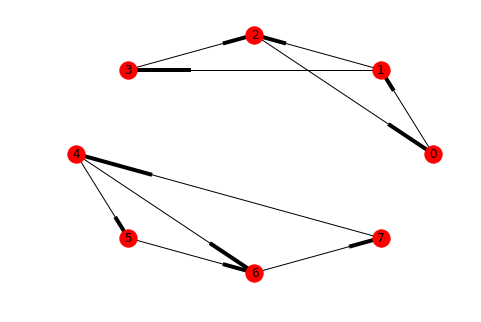

In [3]:
nx.draw(C, pos=nx.circular_layout(C), with_labels=True)
plt.show()

3 observations:
* The graph has 2 disjoint connected components: (0,1,2,3)~(7,4,6,5), thus leading to all the distribution support being present in one of the graphs, wherever the first random node happens to be selected.
*  Moreover, the two components are isomorphic, which explains why identical probabilities appear on both sides at different runs.
* In each connected component, the probability distribution seems to converge to a 1:1:1:0.5 ratio, which corresponds to the stationary distribution of the random walk.

### "Absorbing" Graph

In [4]:
A = nx.read_adjlist('../data/absorbing.graph', create_using=nx.DiGraph(), nodetype=int)
print(random_surf(A, 100000))

[0.0, 1.0, 0.0, 0.0, 0.0]


Let us visualize the graph

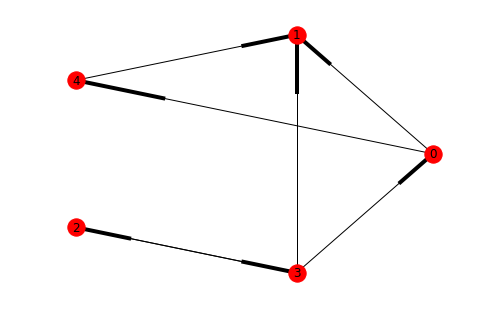

In [5]:
nx.draw(A, pos=nx.circular_layout(A), with_labels=True)
plt.show()

In this graph, node 1 is reachable from every other node, but there is no outgoing edges from it, so it eventually *absorbs* the probability of being at any node.

In both graphs, we can see that plain random surfer model is not enough to capture the popularity of a node. We refine it below.

#### Exercise 2.13

In [6]:
def even_more_random_surf(G, n_iter, damping_factor):
    scores = [0 for i in G.nodes]
    node = random.choice(list(G.nodes))
    scores[node] += 1
    
    for step in range (n_iter-1):
        neighbors = list(G.neighbors(node))
        
        if random.random() < damping_factor:
            # jump to a random node with a probability damping_factor
            node = random.choice(list(G.nodes))
        else: 
            if (len(neighbors) > 0):
                # jump to a random neighbor
                next_node = random.choice(neighbors)
                node = next_node
            else:
                # jump to a random node in the graph
                node = random.choice(list(G.nodes))
        scores[node] += 1
    score_sum = sum(scores)
    scores_normalized = [round(x/score_sum, 4) for x in scores]
    return scores_normalized

### "Components" Graph

[0.1407, 0.1379, 0.1422, 0.0759, 0.1387, 0.0791, 0.1445, 0.1411]


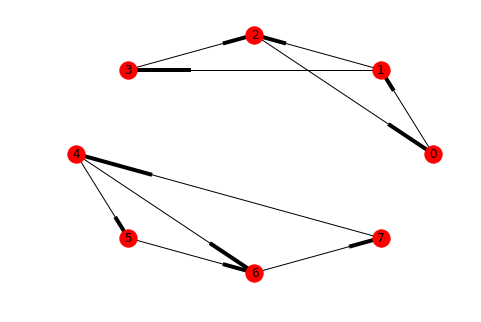

In [7]:
print(even_more_random_surf(C, 100000, 0.15))
nx.draw(C, pos=nx.circular_layout(C), with_labels=True)
plt.show()

The distribution is still pretty similar between the two connected components, and also similar to the previously obatined distribution, which was to be expected. Only now, a full support is observed (resembling 1:1:1:0.5:1:0.5:1:1 again, only the resemblance is not as strong as before, because of increased randomness going on), because the damping factor keeps both of the subgraphs more or less 'equally visited'.

The scores now make sense intuitively. What follows are some intuitive comments about why this is so. <br/>
Node 3 is only half as likely to arrive at as other nodes, because node 1 (the only way to get to node 3, except for a random spawn at 3) has 2 outgoing edges, so 3 is selected only half of the time. Nodes 0 and 1 are identical in that sense, i.e. the node that leads to them leads only to them, and so they have an equal probability of being at (of course, this all depends on the probability of being at the nodes that lead to them in the first place, but this is only an intuitive 'analysis'). Node 2 can be seen as similar, since you can come to 2 through 1 or 3, and tou come to 3 only from 1. So all the probability of being at 1 transfers to 2 in 1 or 2 steps.

### "Absorbing" Graph

[0.1489, 0.3403, 0.1469, 0.2121, 0.1518]


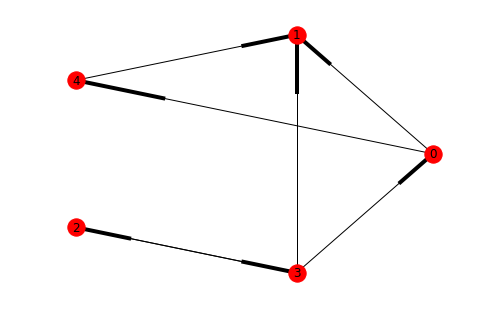

In [8]:
print(even_more_random_surf(A, 100000, 0.15))
nx.draw(A, pos=nx.circular_layout(A), with_labels=True)
plt.show()

Overall, the results are intuitive.
* It makes sense that 1 is the most popular node, as it only has incoming edges i.e. is reachable from every node, but has no outgoing edges. 
* Then, node 3 is more popular than 2 because 2 necessarily (with a 0.85 probability) leads to 3. 
* 2 is more or less the same as 0, because they have the same 'reachability': they are either selected at random among all 5 nodes, or they are arrived at from node 3, so it makes sense that they should have equal probability.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [9]:
import numpy as np
import csv
import pandas as pd
def power_iteration(G, theta, n_iter): # alternatively, could specift error stop margin
    # Compute the transition matrix (H) and the indicator vector of dangling nodes (w)
    N = len(G.nodes)
    H = np.zeros((N, N))
    w = np.zeros(N)
    for u in G.nodes:
        neighbors = list(G.neighbors(u))
        out_degree = len(neighbors)
        if out_degree > 0:
            for v in neighbors:
                H[u][v] = 1 / out_degree
        else:
            w[u] = 1

    H_hat = H + w[:, None] * np.ones(N)/N
    # the final transition matrix
    T = theta * H_hat + (1-theta) * np.ones(N)[:, None] * np.ones(N)/N 
    
    # Iterate until convergence
    pi_stationary = np.ones(N)/N

    for i in range(n_iter):
        pi_stationary = pi_stationary.dot(T)
    return pi_stationary

In [10]:
W = nx.read_adjlist('../data/wikipedia.graph', create_using=nx.DiGraph(), nodetype=int)

We compute $\pi^T$ by power iteration method. The damping factor is again 0.15.

In [11]:
pi_stationary = power_iteration(W, 0.85, 1000)
print (pi_stationary)

[  3.21057121e-04   7.71147931e-05   2.33668621e-04 ...,   7.79645206e-05
   1.10830812e-04   1.25196778e-04]


In [12]:
ten_most_popular_pages = (pi_stationary.argsort()[-10:][::-1])
titles = pd.read_csv('../data/wikipedia_titles.tsv', sep='\t')
print(ten_most_popular_pages)

[5210 5201 2034 1890 2168 1811 5477 2999 2619 1818]


#### And the ten most popular pages on Wikipedia are... \*drum roll*

In [13]:
print('Top 10 pages with the best PageRank score in wikipedia:')
for page in ten_most_popular_pages:
    print(round(pi_stationary[page], 4), ':', titles['page_title'][page])

Top 10 pages with the best PageRank score in wikipedia:
0.0075 : United States
0.0052 : United Kingdom
0.005 : France
0.0045 : Europe
0.004 : Germany
0.0038 : England
0.0037 : World War II
0.0036 : Latin
0.0036 : India
0.0034 : English language


---

### 2.4.3 Gaming the system

#### Exercise 2.15

In [14]:
target_index = list(titles['page_title']).index('History of mathematics')
print('The original PageRank score:', (pi_stationary[target_index]))

The original PageRank score: 9.84634105555e-05


##### Approach 1: make the most popular pages point to History of mathematics

We add a link to 'History of mathematics' to 300 pages with the best PageRank scores.

In [15]:
H1 = nx.DiGraph(W)
top300_most_popular_pages = pi_stationary.argsort()[-302:][::-1] # because, turns out, 2 of them are already have those pointers

for page in top300_most_popular_pages:
    if (page, target_index) not in H1.edges:
        H1.add_edge(page, target_index)
    
pi_approach_1 = power_iteration(H1, 0.85, 1000)
print ('PageRank score via Approach 1:', (pi_approach_1[target_index]))

PageRank score via Approach 1: 0.00465955808171


In [16]:
print('Top 4 pages with the best PageRank score in wikipedia are:')
for page in (pi_approach_1.argsort()[-4:][::-1]):
    print(round(pi_approach_1[page], 4), ':', titles['page_title'][page])

Top 4 pages with the best PageRank score in wikipedia are:
0.0073 : United States
0.0051 : United Kingdom
0.005 : France
0.0047 : History of mathematics


As we can see, it is in top 4 now.

##### Approach 2: add links from nodes with maximal PageRankScore/out-degree

We add links to 'History of mathematics' from nodes with highest score/out-degree. We add 0.01 to out-degree to avoid division by zero. Note that this will result in a lot of nodes which were prviously absorving nodes now point to 'mathematics', which is desireable.

In [17]:
H2 = nx.DiGraph(W)
m = np.array([pi_stationary[x]/(H2.out_degree(x)+0.01) for x in range(len(H2.nodes))])
coolest_pages = (m.argsort())[-302:][::-1] # because, turns out, 2 of them are already have those pointers

for page in coolest_pages:
    if (page, target_index) not in H2.edges:
        H2.add_edge(page, target_index)

pi_approach_2 = power_iteration(H2, 0.85, 1000)
print ('PageRank score via Approach 2:', (pi_approach_2[target_index]))

PageRank score via Approach 2: 0.00669949116528


In [18]:
print('Top 2 pages with the best PageRank score in wikipedia are:')
for page in (pi_approach_2.argsort()[-2:][::-1]):
    print(round(pi_approach_2[page], 4), ':', titles['page_title'][page])

Top 2 pages with the best PageRank score in wikipedia are:
0.0073 : United States
0.0067 : History of mathematics


##### Approach 3: trying to form a superpower of 25 pages i.e. $K_{25}$ clique

In [19]:
# aproach 3: 
H3 = nx.DiGraph(W)
top24_most_popular_pages = (pi_stationary.argsort())[-24:][::-1]
for i in top24_most_popular_pages:
    for j in top24_most_popular_pages:
        if j > i:
            H3.add_edge(i, j)
    H3.add_edge(i, target_index)

pi_approach_3 = power_iteration(H3, 0.85, 1000)
print ('PageRank score via Approach 3:', (pi_approach_3[target_index]))

PageRank score via Approach 3: 0.000780000388322


This approach didn't prove very successful

##### Approach 4: iteratively find the page that contributes the least, and add a link from it

##### Approach 5: add links from nodes with maximal PageRankScore/distance_to_target

Because of the damping factor, a random surfer will jump to a random place on the graph and ditch its current path in 7 hops on average. Thus, the nodes from which mathemtaics is more than 7 hops away don't contribute much to its popularity. We target those nodes in this approach by adding selecting top 300 nodes with maximum PageRankScore/distance_to_target.

In [20]:
# approach 1': the most popular pages that are 7 hops far will point to mathematics
H5 = nx.DiGraph(W)
top300_most_popular_far_nodes = np.array([pi_stationary[x]/nx.shortest_path_length(H5, x, target_index) for x in range(len(H5.nodes)) if nx.has_path(H5, x, target_index) and x != target_index])
top300_most_popular_far_nodes = (top300_most_popular_far_nodes.argsort())[-300:][::-1]

cnt = 0
for page in top300_most_popular_far_nodes:
    if (page, target_index) not in H5.edges:
        cnt +=1
        H5.add_edge(page, target_index)
        
print(cnt)
    
pi_approach_5 = power_iteration(H5, 0.85, 1000)
print ('PageRank score via Approach 5:', (pi_approach_5[target_index]))

300
PageRank score via Approach 5: 0.00210390582279


##### Approach 5 \* 34% + Approach 2 \* 66%

In [21]:
# mix 2 and 5
H25 = nx.DiGraph(W)
mix = np.array([pi_stationary[x]/(H25.out_degree(x)+0.01) for x in range(len(H25.nodes))])
some_coolest_pages = (mix.argsort())[-200:][::-1] # because, turns out, 2 of them are already have those pointers

for page in some_coolest_pages:
    if (page, target_index) not in H25.edges:
        H25.add_edge(page, target_index)
        
other_cool_pages = np.array([pi_stationary[x]/nx.shortest_path_length(H25, x, target_index) for x in range(len(H25.nodes)) if nx.has_path(H25, x, target_index) and x != target_index])
other_cool_pages = (other_cool_pages.argsort())[-146:][::-1]

for page in other_cool_pages:
    if (page, target_index) not in H25.edges:
        H25.add_edge(page, target_index)

pi_approach_25 = power_iteration(H25, 0.85, 1000)
print ('PageRank score via Approach 5 & 2 combined:', (pi_approach_25[target_index]))

PageRank score via Approach 5 & 2 combined: 0.00584249191654


In [22]:
print('Top 2 pages with the best PageRank score in wikipedia are:')
for page in (pi_approach_25.argsort()[-2:][::-1]):
    print(round(pi_approach_25[page], 4), ':', titles['page_title'][page])

Top 2 pages with the best PageRank score in wikipedia are:
0.0073 : United States
0.0058 : History of mathematics


Not bad, but approach 2 alone did better.

##### Approach 6: be like the United States

Here we identify the nodes pointing to 'The United States' - the most popular page, and add a link to them pointing to our target page. Since there are a bit less than 2000 pages pointe

In [23]:
H6 = nx.DiGraph(W)
d = H6.in_degree(5210)
pointing_to_us = []
for i in H6.nodes:
    if (i, 5210) in H6.edges:
        pointing_to_us.append(i)

s = {}
for i in pointing_to_us:
    s[i] = pi_stationary[i]
sorted_s = sorted(s.items(), key=lambda kv: kv[1]/(H6.out_degree(kv[0])+0.01), reverse=True)
keyz = [k for k, v in sorted_s]

for i in range(300):
    H6.add_edge(keyz[i], target_index)

pi_approach_6 = power_iteration(H6, 0.85, 1000)
print ('PageRank score via Approach 6:', (pi_approach_6[target_index]))

PageRank score via Approach 6: 0.00342237494356


##### Best Performance

Approach 2 proved best, increasing the score of History of mathematics to 0.0067, making it the second most popular page on wikipedia.